In [1]:
import QGL.config
import auspex.config
auspex.config.AWGDir = "/home/qlab/Edison/AWG"
QGL.config.AWGDir = "/home/qlab/Edison/AWG"
from QGL import *
output_notebook()
from auspex.qubit import *

Loading BokehJS ...

In [2]:
from auspex.instruments import APS2

In [3]:
cl = ChannelLibrary(db_resource_name=":memory:")
pl = PipelineManager()

q1 = cl.new_qubit("q1")
aps2_1 = cl.new_APS2("BBNAPSa", address="192.168.2.4") 
aps2_2 = cl.new_APS2("BBNAPSb", address="192.168.2.2")
dig_1  = cl.new_Alazar("Alazar_1", address="1")
h1 = cl.new_source("BNC1", "BNC845", "192.168.5.165", power=13)
h2 = cl.new_source("Agilent1", "AgilentN5183A", "192.168.5.105", power=10)

In [4]:
cl.set_measure(q1, aps2_1, dig_1.ch("1"), trig_channel=aps2_1.ch("m2"), gate=False, generator=h1)
cl.set_control(q1, aps2_2, generator=h2)
cl.set_master(aps2_1, aps2_1.ch("m1"))
cl["q1"].measure_chan.frequency = 0e6
cl["q1"].measure_chan.autodyne_freq = 10e6

In [5]:
aps2_1.trigger_interval = 200e-6

In [6]:
pl.create_default_pipeline()
pl["q1"].clear_pipeline()
pl["q1"].set_stream_type("raw")
pl["q1"].create_default_pipeline()

In [7]:
pl["q1"]["Demodulate"]["Integrate"]["Average"].add(Display(label="PlotAverage"))

Display PlotAverage (q1)

In [8]:
pl["q1"]["Demodulate"]["Integrate"]["Average"].add(Display(label="Plot1D"))

Display Plot1D (q1)

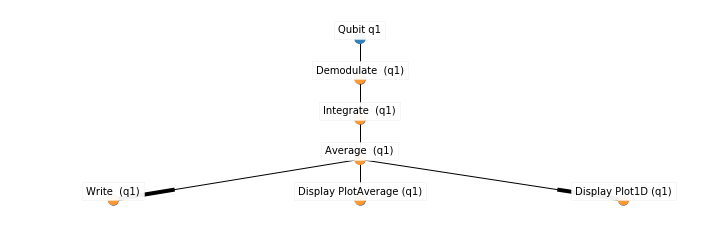

In [9]:
pl.show_pipeline()

In [10]:
plotter = pl["q1"]["Demodulate"]["Integrate"]["Average"]["PlotAverage"]

In [11]:
plotter1D = pl["q1"]["Demodulate"]["Integrate"]["Average"]["Plot1D"]

In [12]:
# add a 1D plotter to watch step by step updates during 2D scans
plotter1D.plot_dims = 1

In [13]:
# optionally add raw and demod plotters
# plotterDemod = pl["q1"]["Demodulate"].add(Display(label="PlotDemod"))
# plotterDemod.plot_dims = 1

In [14]:
q1.measure_chan.pulse_params['length'] = 2e-6
q1.measure_chan.pulse_params['amp'] = 0.85

Initialize Measure APS Parameters

In [15]:
m_aps = cl['BBNAPSb-1']

In [16]:
IQamp = 0.85
m_aps.I_channel_amp_factor = IQamp
m_aps.Q_channel_amp_factor = IQamp


initialize SW demodulator parameters

In [17]:
demod = pl["q1"]["Demodulate"]

In [18]:
demod.frequency = cl["q1"].measure_chan.frequency
demod.decimation_factor = 16

In [19]:
integ = pl["q1"]["Demodulate"]["Integrate"]

In [20]:
integ.box_car_start = 0.2e-6
integ.box_car_stop= 1.9e-6

In [21]:
dig_1.sampling_rate = 500e6
dig_1.record_length = 1024

In [22]:
writer = pl["q1"]["Demodulate"]["Integrate"]["Average"]["Write"]

In [23]:
writer.filename = "/home/qlab/Edison/data/Spec.h5"
writer.add_date = True

See changes since our last DB commit; commit changes to remove "dirty/unstaged"

In [24]:
cl.session.dirty

IdentitySet([Receiver('Alazar_1'), PhysicalQuadratureChannel('BBNAPSb-1'), Demodulate None (q1), Integrate None (q1), Measurement('M-q1'), Write None (q1)])

In [25]:
cl.session.commit()

In [26]:
cl.session.dirty

IdentitySet([])

In [27]:
mf = PulsedSpec(q1,specOn=False)
plot_pulse_files(mf)

Compiled 1 sequences.


In [ ]:
fstart = 6.512e9
fstop = 6.522e9
nsteps = 40
exp = QubitExperiment(mf, averages=100)
exp.add_qubit_sweep(q1,"measure", "frequency", np.linspace(fstart, fstop, nsteps))
exp.add_qubit_sweep(q1,"measure", "amplitude", np.linspace(0.05,0.6,10))
exp.run_sweeps()

In [28]:
h1.frequency = 6.52e9
IQamp = 0.2
m_aps.I_channel_amp_factor = IQamp
m_aps.Q_channel_amp_factor = IQamp

In [29]:
q1.pulse_params['length'] = 3e-6
q1.frequency = 0
q1.pulse_params['amp'] = 0.85
q1.pulse_params['shape_fun'] = 'tanh'

In [30]:
q1.pulse_params

{'amp': 0.85,
 'cutoff': 2,
 'drag_scaling': 0,
 'length': 3e-06,
 'pi2Amp': 0.5,
 'piAmp': 1.0,
 'shape_fun': 'tanh',
 'sigma': 5e-09}

In [31]:
mf = PulsedSpec(q1,specOn=True)
plot_pulse_files(mf)

Compiled 1 sequences.


In [32]:
fstart = 4.81e9
fstop = 4.91e9
nsteps = 201
exp = QubitExperiment(mf, averages=100)
exp.add_qubit_sweep(q1,"control", "frequency", np.linspace(fstart, fstop, nsteps))
exp.run_sweeps()

auspex-INFO: 2018-12-21 16:28:27,676 ----> Connection established to plot server.


In [33]:
h2.frequency = 4.86e9
q1.pulse_params['length'] = 100e-9

In [34]:
fstart = 4.81e9
fstop = 4.92e9
nsteps = 21
mf = RabiWidth(q1,np.linspace(20e-9,2e-6,41))
exp = QubitExperiment(mf,averages=100)
exp.add_qubit_sweep(q1,"control", "frequency", np.linspace(fstart, fstop, nsteps))
exp.run_sweeps()

Compiled 41 sequences.
auspex-INFO: 2018-12-21 16:29:48,052 ----> Connection established to plot server.
